In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import lagrange

# Atmospheric Model

### Model Declaration

In [4]:
# Real data
file_path = 'Data/air.xlsx'
df_excel = pd.read_excel(file_path)
data = df_excel.iloc[:, :5].select_dtypes(include=[np.number])
data.head()

,Altitude [km],Temperature [K],Pressure [Pa],Density [kg/m3],Speed of sound [m/s]
0,0.0,288.15,101325.0,1.225000,340.294
1,1.0,281.65,89874.6,1.111640,336.434
2,2.0,275.15,79495.2,1.006490,332.529
3,3.0,268.65,70108.5,0.909122,328.578
4,4.0,262.15,61640.2,0.819129,324.579


In [5]:
def compute_atmos_simple(h, gamma=1.4):
    """
    Calcule la température (T) en Kelvin et la pression (P) en Pascal à une altitude h (en mètres)
    en utilisant le modèle ISA.
    
    Parameters:
        h (float): altitude en mètres
        gamma (float): rapport des capacités calorifiques (par défaut 1.4 pour l'air)
        
    Returns:
        tuple: (T, P, a) où T est la température en K, P est la pression en Pa,
			   et a est la vitesse du son en m/s à l'altitude h. 
    """
    # Constantes de l'atmosphère standard
    T0 = 288.15        # Température au niveau de la mer en K
    P0 = 101325        # Pression au niveau de la mer en Pa
    L = 0.0065         # Gradient thermique en K/m dans la troposphère
    g = 9.80665        # Accélération gravitationnelle en m/s^2
    R = 287.05         # Constante spécifique de l'air en J/(kg·K)
    
    if h <= 11000:
        # Dans la troposphère, la température décroît linéairement
        T = T0 - L * h
        # La pression s'obtient par intégration de l'équilibre hydrostatique
        exponent = g / (R * L)
        P = P0 * (T / T0) ** exponent
    else:
        # Pour h > 11000 m, on utilise la zone isotherme
        # On calcule d'abord les conditions à la base de la zone isotherme (h_base = 11000 m)
        h_base = 11000
        T_base = T0 - L * h_base  # Température à 11000 m, normalement 216.65 K
        exponent = g / (R * L)
        P_base = P0 * (T_base / T0) ** exponent  # Pression à 11000 m
        
        # Dans la zone isotherme, T est constant et égal à T_base
        T = T_base
        # La pression décroît de façon exponentielle
        P = P_base * math.exp(-g * (h - h_base) / (R * T))
        
    a = math.sqrt(gamma * R * T)  # Vitesse du son en m/s
        
    return T, P, a  # Retourne la température, pression et vitesse du son

In [6]:
def compute_atmos_nasa(alt, planet=0):
    """
    Compute atmospheric properties (temperature, pressure, density, speed of sound)
    using an approximate NASA-style piecewise atmosphere in strictly metric units.

    Parameters:
        alt (float): Geometric altitude in meters.
        planet (int): 0 for Earth (default), 1 for Mars.

    Returns:
        dict: {
            "temp": Static temperature in Kelvin (K),
            "press": Static pressure in Pascals (Pa),
            "rho": Density in kg/m^3,
            "a0": Speed of sound in m/s
        }
    """

    if planet == 0:
        # -----------------------------------------------------------
        # Earth standard atmosphere (approximate piecewise)
        # -----------------------------------------------------------
        gamma = 1.4
        R = 287.053  # J/(kg·K) for air

        # ---------------------------
        # 1) Troposphere up to ~11 km
        # ---------------------------
        #   T = T0 - L * h
        #   P = P0 * (T / T0)^(5.256)
        # where:
        #   T0 = 288.11 K
        #   P0 = 101333 Pa
        #   L = 0.00649 K/m 
        #
        # Altitude break is ~ 11,000 m (≈ 36,152 ft)
        #
        if alt <= 11000.0:
            T = 288.11 - 0.00649 * alt
            P = 101333.0 * (T / 288.11) ** 5.256

        # --------------------------------
        # 2) Lower stratosphere, 11–25 km
        # --------------------------------
        #   T = 216.66 K (constant)
        #   P = P(11 km) * exp[-g / (R*T) * (h - 11000)]
        #
        # Altitude break is ~ 25,078 m (≈ 82,345 ft)
        #
        elif alt <= 25078.0:
            T = 216.66  # ~ 389.98 R / 1.8

            # Pressure at 11 km, from the troposphere formula:
            T_trop = 288.11 - 0.00649 * 11000.0
            P_trop = 101333.0 * (T_trop / 288.11) ** 5.256

            # Exponential drop in isothermal layer:
            g0 = 9.80665
            P = P_trop * math.exp(-g0 / (R * T) * (alt - 11000.0))

        # -------------------------------
        # 3) Upper stratosphere, above 25 km
        # -------------------------------
        #   T = 216.66 + dT/dh * (h - 25078)
        #        (where dT/dh ~ 0.003 K/m from the original slope)
        #
        #   P = P(25 km) * (T / T(25 km))^(-11.388)
        #        (the exponent ~ -g/(R*dT/dh) from a polytropic segment)
        
        else:
            # Temperature
            dT_dh = 0.003  # ~ 1.645 R per 1000 ft => ~0.91 K per 304.8 m => ~0.003 K/m
            T_base = 216.66  # temperature at 25 km
            T = T_base + dT_dh * (alt - 25078.0)

            # Pressure at 25 km (continuing from region 2)
            g0 = 9.80665
            P_trop = 101333.0 * (
                (288.11 - 0.00649 * 11000.0) / 288.11
            ) ** 5.256
            P_strat_25 = P_trop * math.exp(-g0 / (R * 216.66) * (25078.0 - 11000.0))

            # polytropic (T / T_base)^(-11.388)
            P = P_strat_25 * (T / T_base) ** (-11.388)

        # Derived properties in SI
        rho = P / (R * T)         	 	# kg/m^3
        a0 = math.sqrt(gamma * R * T)  	# m/s

    elif planet == 1:
        # -----------------------------------------------------------
        # Mars atmosphere
        # -----------------------------------------------------------
        #   R ~ 188.9 J/(kg·K) 
        #   gamma ~ 1.29
    
        gamma = 1.29
        R = 188.92  # J/(kg·K), approximate for Mars
        g0 = 3.711  # m/s^2 on Mars (optional if you do more advanced layering)

        if alt <= 7000.0:
            # Lower region
            # T base ~ 434.02 R => 241.12 K at h=0
            # slope ~ 0.001 K/m
            T = 241.12 - 0.001 * alt
            # P = 700 Pa * exp(-9.8425e-5 * alt)
            P = 700.0 * math.exp(-9.8425e-5 * alt)
        else:
            # Upper region
            # T base ~ 449.36 R => 249.64 K at h=0
            # slope ~ 0.0022 K/m
            T = 249.64 - 0.00222 * alt
            P = 700.0 * math.exp(-9.8425e-5 * alt)

        rho = P / (R * T)
        a0 = math.sqrt(gamma * R * T)

    else:
        raise ValueError("Unsupported planet index. Use 0 for Earth or 1 for Mars.")

    return {
        "temp":  T,       # Kelvin
        "press": P,       # Pascals
        "rho":   rho,     # kg/m^3
        "a0":    a0       # m/s
    }


In [7]:
def compute_atmos_aprox_dataset(alt, dataset):
    """
    Compute atmospheric properties (temperature, pressure, density, speed of sound)
    using a linear interpolation from a dataset.

    Parameters:
        alt (float): Geometric altitude in meters.
        dataset (DataFrame): DataFrame containing atmospheric data with columns for
                             altitude, temperature, pressure, density, and speed of sound.

    Returns:
        dict: {
            "temp": Static temperature in Kelvin (K),
            "press": Static pressure in Pascals (Pa),
            "rho": Density in kg/m^3,
            "a0": Speed of sound in m/s
        }
    """
    
    # Interpolation for each property
    temp = np.interp(alt, dataset['Altitude [km]']*1000, dataset['Temperature [K]'])
    press = np.interp(alt, dataset['Altitude [km]']*1000, dataset['Pressure [Pa]'])
    rho = np.interp(alt, dataset['Altitude [km]']*1000, dataset['Density [kg/m3]'])
    a0 = np.interp(alt, dataset['Altitude [km]']*1000, dataset['Speed of sound [m/s]'])

    return {
        "temp":  temp,
        "press": press,
        "rho":   rho,
        "a0":    a0
    }

### Model Test

In [8]:
simple_rows = []
nasa_rows = []
aprox_rows = []

for alt_km in data['Altitude [km]']:
    # Convert altitude from km to meters for the simple model
    T_simple, P_simple, a_simple = compute_atmos_simple(alt_km * 1000.0)
    simple_rows.append({
        'Altitude [km]': alt_km,
        'T_simple [K]': T_simple,
        'P_simple [Pa]': P_simple,
        'a_simple [m/s]': a_simple
    })
    
    # If compute_atmos_nasa expects altitude in meters, also multiply by 1000
    atmos_nasa = compute_atmos_nasa(alt_km * 1000.0, planet=0)
    nasa_rows.append({
        'Altitude [km]': alt_km,
        'T_nasa [K]': atmos_nasa['temp'],
        'P_nasa [Pa]': atmos_nasa['press'],
        'a_nasa [m/s]': atmos_nasa['a0']
    })
    
    # For the approximate dataset, we can use the same altitude in meters
    aprox = compute_atmos_aprox_dataset(alt_km * 1000.0, df_excel)
    aprox_rows.append({
        'Altitude [km]': alt_km,
        'T_aprox [K]': aprox['temp'],
        'P_aprox [Pa]': aprox['press'],
        'a_aprox [m/s]': aprox['a0']
    })
    

# Convert the lists of dictionaries into DataFrames
results_simple = pd.DataFrame(simple_rows)
results_nasa = pd.DataFrame(nasa_rows)
results_aprox = pd.DataFrame(aprox_rows)

# Merge the results with the original data

results = pd.merge(data, results_simple, on='Altitude [km]')
results = pd.merge(results, results_nasa, on='Altitude [km]')
results = pd.merge(results, results_aprox, on='Altitude [km]')

results.head()

,Altitude [km],Temperature [K],Pressure [Pa],Density [kg/m3],Speed of sound [m/s],T_simple [K],P_simple [Pa],a_simple [m/s],T_nasa [K],P_nasa [Pa],a_nasa [m/s],T_aprox [K],P_aprox [Pa],a_aprox [m/s]
0,0.0,288.15,101325.0,1.225000,340.294,288.15,101325.000000,340.292287,288.11,101333.000000,340.270445,288.15,101325.0,340.294
1,1.0,281.65,89874.6,1.111640,336.434,281.65,89874.455159,336.432290,281.62,89896.675281,336.416130,281.65,89874.6,336.434
2,2.0,275.15,79495.2,1.006490,332.529,275.15,79495.009084,332.527488,275.13,79528.677487,332.517140,275.15,79495.2,332.529
3,3.0,268.65,70108.5,0.909122,328.578,268.65,70108.268340,328.576286,268.64,70150.923498,328.571887,268.65,70108.5,328.578
4,4.0,262.15,61640.2,0.819129,324.579,262.15,61639.907430,324.576987,262.15,61689.376362,324.578683,262.15,61640.2,324.579


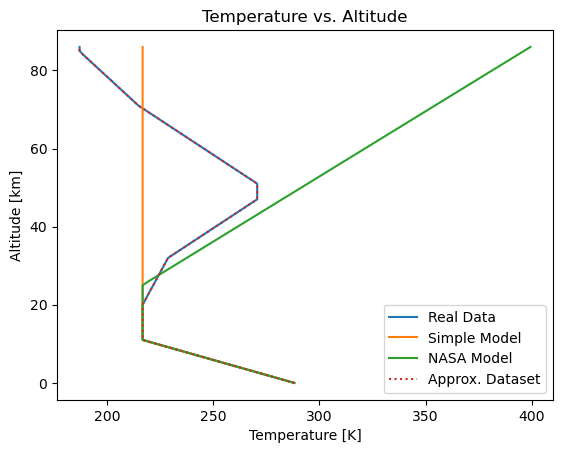

In [9]:
def plot_temperature_vs_altitude(results):
    plt.figure()
    plt.plot(results['Temperature [K]'], results['Altitude [km]'], label='Real Data')
    plt.plot(results['T_simple [K]'], results['Altitude [km]'], label='Simple Model')
    plt.plot(results['T_nasa [K]'], results['Altitude [km]'], label='NASA Model')
    plt.plot(results['T_aprox [K]'], results['Altitude [km]'], label='Approx. Dataset', linestyle='dotted')
    plt.xlabel('Temperature [K]')
    plt.ylabel('Altitude [km]')
    plt.title('Temperature vs. Altitude')
    plt.legend()
    plt.show()
    
plot_temperature_vs_altitude(results)

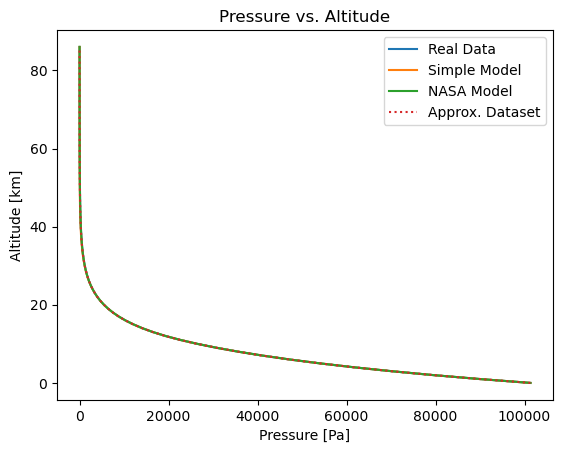

In [10]:
def plot_pressure_vs_altitude(results):
    plt.figure()
    plt.plot(results['Pressure [Pa]'], results['Altitude [km]'], label='Real Data')
    plt.plot(results['P_simple [Pa]'], results['Altitude [km]'], label='Simple Model')
    plt.plot(results['P_nasa [Pa]'], results['Altitude [km]'], label='NASA Model')
    plt.plot(results['P_aprox [Pa]'], results['Altitude [km]'], label='Approx. Dataset', linestyle='dotted')
    plt.xlabel('Pressure [Pa]')
    plt.ylabel('Altitude [km]')
    plt.title('Pressure vs. Altitude')
    plt.legend()
    plt.show()
    
plot_pressure_vs_altitude(results)


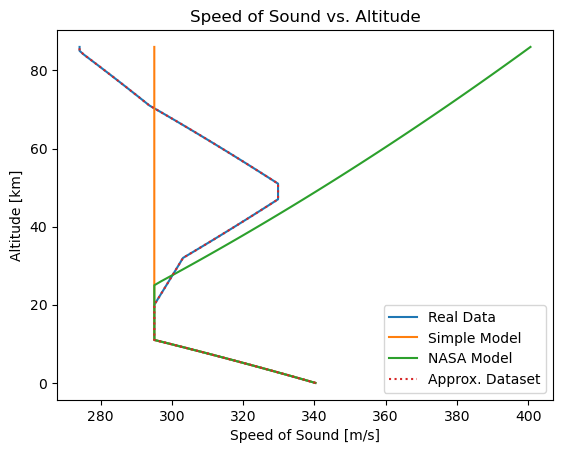

In [11]:
def plot_speed_of_sound_vs_altitude(results):
    plt.figure()
    plt.plot(results['Speed of sound [m/s]'], results['Altitude [km]'], label='Real Data')
    plt.plot(results['a_simple [m/s]'], results['Altitude [km]'], label='Simple Model')
    plt.plot(results['a_nasa [m/s]'], results['Altitude [km]'], label='NASA Model')
    plt.plot(results['a_aprox [m/s]'], results['Altitude [km]'], label='Approx. Dataset', linestyle='dotted')
    plt.xlabel('Speed of Sound [m/s]')
    plt.ylabel('Altitude [km]')
    plt.title('Speed of Sound vs. Altitude')
    plt.legend()
    plt.show()
    
plot_speed_of_sound_vs_altitude(results)

# Computation Class

In [12]:
def compute_mach_number(v, a):
	"""
	Calcule le nombre de Mach à partir de la vitesse (v) et de la vitesse du son (a).
	
	Parameters:
		v (float): vitesse en m/s
		a (float): vitesse du son en m/s
		
	Returns:
		float: nombre de Mach
	"""
	return v / a  # Retourne le nombre de Mach

In [13]:
def compute_mach_number_from_PT(v, P, T, gamma=1.4, R=287.05):
	"""
	Calcule le nombre de Mach à partir de la vitesse (v), de la pression (P) et de la température (T).
	
	Parameters:
		v (float): vitesse en m/s
		P (float): pression en Pa
		T (float): température en K
		gamma (float): rapport des capacités calorifiques (par défaut 1.4 pour l'air)
		R (float): constante spécifique de l'air en J/(kg·K)
		
	Returns:
		float: nombre de Mach
	"""
	# Calculer la vitesse du son à partir de la température
	a = math.sqrt(gamma * R * T)
	
	# Retourner le nombre de Mach
	return v / a

In [14]:
def compute_speed(M, P, T, gamma=1.4, R=287.05):
	"""
	Calcule la vitesse à partir du nombre de Mach (M), de la pression (P) et de la température (T).
	
	Parameters:
		M (float): nombre de Mach
		P (float): pression en Pa
		T (float): température en K
		gamma (float): rapport des capacités calorifiques (par défaut 1.4 pour l'air)
		R (float): constante spécifique de l'air en J/(kg·K)
		
	Returns:
		float: vitesse en m/s
	"""
	# Calculer la vitesse du son à partir de la température
	a = math.sqrt(gamma * R * T)
	
	# Retourner la vitesse
	return M * a


# Computation for Project

In [15]:
# Computation of speed for Mach number at 70km

altitude = 0  	# in km
Mach = 1 		# Example Mach number


aprox = compute_atmos_aprox_dataset(altitude * 1000.0, df_excel)
T = aprox['temp']
P = aprox['press']
a = aprox['a0']

# Compute the speed of the aircraft at the given Mach number
speed = Mach * a  # in m/s

print(f"At {altitude} km and Mach {Mach}, the speed is {speed:.2f} m/s, with a temperature of {T:.2f} K, pressure of {P:.2f} Pa, and speed of sound of {a:.2f} m/s.")


At 0 km and Mach 1, the speed is 340.29 m/s, with a temperature of 288.15 K, pressure of 101325.00 Pa, and speed of sound of 340.29 m/s.


In [16]:
temp = 293.2
pressure = 101325.0
Mach = 6

param = compute_speed(Mach, pressure, temp)
print(f"At {temp} K and {pressure} Pa, the speed for Mach {Mach} is {param:.2f} m/s.")

At 293.2 K and 101325.0 Pa, the speed for Mach 6 is 2059.57 m/s.
